In [ ]:
import numpy as np
from skimage import data, io, filters
from matplotlib import pyplot as plt
from PIL import Image
from skimage.transform import resize
import random
%matplotlib inline

In [ ]:
# Number of cities
# Generating the 10 random points between 0 and 1 and storing tham in city_x and city_y array
N = 10

city_x = np.random.rand((10))
city_y = np.random.rand((10))

print('The co-ordinates of the 10 cities are:')
for city in zip(city_x, city_y):
    print(city)

The co-ordinates of the 10 cities are:
(0.5868049708707317, 0.33515993594687343)
(0.6745983401738592, 0.8840485368972216)
(0.3606474001577742, 0.4080916433281344)
(0.830386367920734, 0.7051376497908406)
(0.3804281639100282, 0.6433892932305992)
(0.7652034651580247, 0.1651428696231021)
(0.09992588891925225, 0.36074224411250566)
(0.5181643463738399, 0.9859834847023625)
(0.3993690050315435, 0.2234231384992239)
(0.5225384447449909, 0.26795927216412907)


Text(0.5, 1.0, 'Map of cities')

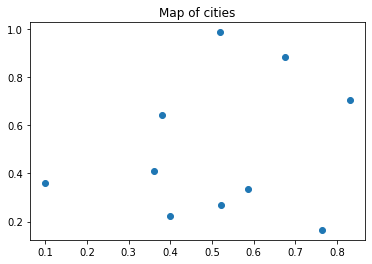

In [ ]:
plt.plot(city_x, city_y, 'o')
plt.title('Map of cities')

In [ ]:
d = np.zeros((N,N))
# Calculate distance matrix
for i in range(N):
    for j in range(N):
        d[i, j] = np.sqrt((city_x[i] - city_x[j])**2 + (city_y[i] - city_y[j])**2)

print(d);

[[0.         0.55586543 0.23762635 0.44296208 0.37094032 0.24643828
  0.48755071 0.65443321 0.21821401 0.09298449]
 [0.55586543 0.         0.57017555 0.23723199 0.38006968 0.72459275
  0.77723735 0.18671456 0.7156655  0.63457718]
 [0.23762635 0.57017555 0.         0.55577966 0.23612764 0.47190011
  0.26498617 0.5989746  0.18868444 0.2141163 ]
 [0.44296208 0.23723199 0.55577966 0.         0.45417535 0.54391467
  0.80757706 0.41994878 0.64639372 0.53469176]
 [0.37094032 0.38006968 0.23612764 0.45417535 0.         0.6138173
  0.39820959 0.36924522 0.42039306 0.40142625]
 [0.24643828 0.72459275 0.47190011 0.54391467 0.6138173  0.
  0.69343592 0.85720922 0.37044762 0.26354796]
 [0.48755071 0.77723735 0.26498617 0.80757706 0.39820959 0.69343592
  0.         0.75223003 0.32942786 0.43267777]
 [0.65443321 0.18671456 0.5989746  0.41994878 0.36924522 0.85720922
  0.75223003 0.         0.77175813 0.71803754]
 [0.21821401 0.7156655  0.18868444 0.64639372 0.42039306 0.37044762
  0.32942786 0.771758

In [ ]:
# Set parameters for network energy function
# These values have been chosen based on trial and error to achieve good results for solving the TSP problem
# These Parameters are used in the network energy function, which is used to calculate the energy of the Hopfield network
#A : controls the impact of connections between the nodes in the same column of the weight matrix.
#B : controls the impact of connections between the nodes in the same row of the weight matrix.
#C : controls the overall level of activation in the network.
#D : controls the input of the connection between b/w  neighboring nodes.
A = 500 # penalize short edges and encourage long edges.
B = 500 # penalize the intersection of edges. 
C = 1000 # encourage the edges to connect to each other in a cycle.
D = 500 # encourage the edges to connect to each other in a cycle.
alpha = 0.0001 #to control the strength of the weigth update during learning
# Parameter alpha is the learning rate of the Hopfield network, and determines how quickly the network learns to minimize its energy.

In [ ]:
# x-v-value of each node, y-u-input potential, u0-gamma

def hopfield():
    # scaling parameter used in the Hopfield network which shows the quality of the solution
    #v - initial state of the network which will converge towards soln for TSP
    #u - input potential of each node. 
    u0 = 0.02 
    toend = 0
    #This array is used to store the derivatives of the network energy function with respect to the input potential u.
    udao = np.zeros((N, N)) 
    # This variable is used to keep track of the number of iterations it takes for the algorithm to converge
    ctr = 0
    # Starts a while loop that runs until toend is set to 1, 
    # which happens when a valid solution to the TSP is found.
    while toend == 0:
        ctr += 1
        # U initialization
        # Initializes the node values v and the input potential u 
        # using random values and a formula that depends on the number of cities N
        v = np.random.rand(N,N)
        u = np.ones([N, N])*(-u0*np.log(N-1)/2)
        u += u*0.91
        for _ in range(1000):
            # Starts two nested for loops that iterate over all pairs of nodes in the network. 
            # vx is the index of the row and vi is the index of the column.
            for vx in range(N):
                for vi in range(N):
                    j1, j2, j3, j4 = 0, 0, 0, 0
                    #these are the parameters calculated to update the u of node in the direction that will reduce the energy function.
                    #these will help us to penalize the network

                    # derivative 1 (sum over columns j!=vi)
                    # Calculates the first derivative of the network energy function 
                    # with respect to u[vx, vi]. 
                    # This derivative depends on the sum of the node values in the same row as vx, 
                    # excluding the node value in column vi.
                    for j in range(N):
                        if j != vi:
                            j1 += v[vx, j]
                    j1 *= -A
                    # the energy of the network is increased when there are multiple nodes with value 1 in the same row. 
                    # This encourages the network to converge to a state where each row has at most one node with value 1.

                    # derivative 2 (sum over rows y!=x)
                    # Calculates the second derivative of the network energy function 
                    # with respect to u[vx, vi]. 
                    # This derivative depends on the sum of the node values in the same column as vi, 
                    # excluding the node value in row vx.
                    
                    for y in range(N):
                        if y != vx:
                            j2 += v[y, vi]
                    j2 *= -B
                    # penalty associated with two cities in the same row being selected at the same time.

                    # derivative 3 (overall sum)
                    # Calculates the third derivative of the network energy function
                    # with respect to u[vx, vi]. 
                    # This derivative depends on the overall sum of the node values in the network.
                    j3 = np.sum(v)
                    j3 = -C*(j3-N)
                    #  penalize the network if the number of nodes with value 1 is not equal to N. 
                    # Specifically, if the number of nodes with value 1 is less than N, 
                    # j3 will be negative, and the larger the difference, the more negative j3 will be, 
                    # penalizing the network more. If the number of nodes with value 1 is greater than N, 
                    # j3 will be positive, and the larger the difference, the more positive j3 will be, penalizing the network more. 
                    # Only if the number of nodes with value 1 is exactly equal to N will j3 be zero.

                    # derivative 4
                    # used as a penalty for the network to ensure that only one city is visited in each step of the tour.
                    # The purpose of this contribution is to increase the energy (or cost) of the network when two adjacent cities are skipped in the tour, 
                    # thereby incentivizing the network to visit all cities in the tour.
                    for y in range(N):
                        if y != vx:
                            if vi == 0:
                                j4 += d[vx, y]*(v[y, vi+1]+v[y, N-1])
                            elif vi == N-1:
                                j4 += d[vx, y]*(v[y, vi-1]+v[y, 0])
                            else:
                                j4 += d[vx, y]*(v[y, vi+1]+v[y, vi-1])
                    j4 *= -D
                    # The penalty is proportional to the value of D, so increasing D will increase the penalty and make it less likely for the network to have many nodes with value 1.
                    udao[vx, vi] = -u[vx, vi]+j1+j2+j3+j4
                  
                    # Finally, the code updates the status and derivatives by adding the derivative times the learning rate alpha to the current potentials (u). 
                    # The code then calculates the node values (v) by applying a sigmoid function to the potentials, 
                    # which is used to threshold the node values to either 0 or 1.

          

            u = u + alpha*udao

            # calculate node value from input potential u
            # calculates the output value of each neuron based on its current internal potential.
            # np.tanh generates the number between -1 to 1 and whole expression converts is to 0 to 1
            # This sigmoidal function is commonly used in neural networks to introduce nonlinearity and ensure that the output values are bounded
            v = (1+np.tanh(u/u0)) / 2


            # threshold
            # This effectively discretizes the output of the neural network into binary values (0 or 1) based on a threshold.
            # thresholding step is used to convert the output values from the Hopfield network to binary values.  
            for vx in range(N):
                for vi in range(N):
                    if(v[vx, vi] < 0.7):
                        v[vx, vi] = 0
                    if(v[vx, vi] >= 0.7):
                        v[vx, vi]=1

        # testing whether solution is legal
        t1, t2, t3 = 0, 0, 0

        # require total of N-nodes with 1 value
        # checking whether the total number of nodes with value 1 equals N, the total number of nodes in the network. 
        # iterating over all nodes and counting the number of nodes with value 1
        # require total of N-nodes with 1 value
        t1=0
        for vx in range(N):
            for vi in range(N):
                t1+=v[vx, vi]

        # allow only one node in each row equal 1
        # checking whether each row of the network has at most one node with value 1.
        # iterating over all rows and all pairs of nodes within the row, and checking whether both nodes have value 1
        # allow only one node in each row equal 1
        t2=0
        for x in range(N):
            for i in range(N-1):
                for j in range(i+1, N):
                    t2+=np.multiply(v[x, i], v[x, j])

        # allow only one node in each column equal 1
        # checks that there is at most one node with a value of 1 in each column of the network.
        # allow only one node in each column equal 1
        t3=0
        for i in range(N):
            for x in range(N-1):
                for y in range(x+1, N):
                    t3+=np.multiply(v[x, i], v[y, i])

        # stop the loop after getting the valid solution
        if t1 == N and t2 == 0 and t3 == 0:
            toend = 1
        else:
            toend = 0
    # returns the resulting matrix v and the number of iterations ctr that were required to obtain a valid solution.
    return(v, ctr)

In [ ]:
# This function takes the binary matrix v as input, 
# extracts the coordinates of the cities (nodes) in the tour, and calculates the total distance traveled in the tour. 
# It returns the total distance as well as the x- and y-coordinates of the cities in the tour
#calculates the total distance of the path obtained by visiting the cities in the order specified by the input binary matrix

def total_distance(v):
    city_x_final = np.zeros((N+1))
    city_y_final = np.zeros((N+1))

    for j in range(N):
        for i in range(N):
            if v[i,j] == 1:
                city_x_final[j] = city_x[i]
                city_y_final[j] = city_y[i]

    city_x_final[N] = city_x_final[0]
    city_y_final[N] = city_y_final[0]

    # calculate the total distance
    td = 0
    for i in range(N-1):
        td += np.sqrt((city_x_final[i] - city_x_final[i+1])**2
                    + (city_y_final[i] - city_y_final[i+1])**2)
    td += np.sqrt((city_x_final[N-1] - city_x_final[0])**2
                + (city_y_final[N-1] - city_y_final[0])**2)
    
    return(td, city_x_final, city_y_final)

In [ ]:
#It initializes a v matrix with zeros
v = np.zeros([N,N])

ct = 0

min_dist = 20
best_path = None

# runs the hopfield() function 20 times and 
# at each iteration, checks if the resulting path has a lower total distance than the current minimum distance. 
# If the total distance is less than the previous minimum distance, 
# it updates the minimum distance and stores the binary matrix as the best path

for i in range(20):
    v, steps = hopfield()
    print(v)
    td, _, _ = total_distance(v)
    print(f"Epoch {i}: Ran for {steps} steps, total distance {td}")
    if td < min_dist:
        min_dist = td
        best_path = v
print(min_dist)
print(best_path)
# At the end of the loop, it prints the final minimum distance and the best path found.


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Epoch 0: Ran for 13 steps, total distance 3.3233486623836566
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Epoch 1: Ran for 3 steps, total distance 3.2490695643593552
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.

In [ ]:
# takes in a Hopfield network state v and returns a string representation of the optimal route for the Traveling Salesman Problem (TSP) found by the network.
# The function does this by iterating over each column of the state matrix and appending the index of the row with the highest activation to a string, 
# separated by arrows ->. Finally, the first index is appended to the end to create a cycle.
#search for 1 column wise in  the best path matrix
def get_route(v):
    route = ""
    for j in range(v.shape[1]):
        route += str(np.argmax(v[:, j])) + ' -> '
    return (route + str(np.argmax(v[:, 0])))
#For each column, it finds the row with the highest value (which will be 1 in the case of the Hopfield network), using the np.argmax() function.
#after the loop has finished, it appends the index of the first city to the route string to complete the tour.

# For example, if v is a 5x5 matrix representing the optimal state of the Hopfield network for the TSP, 
# get_route(v) might return the string "3 -> 1 -> 0 -> 4 -> 2 -> 3", indicating that the optimal route starts at node 3, 
# then goes to node 1, node 0, and so on, before returning to node 3 to complete the cycle.    

In [ ]:
print(get_route(best_path))

9 -> 8 -> 6 -> 2 -> 4 -> 7 -> 1 -> 3 -> 5 -> 0 -> 9


In [ ]:

def get_route_indices(v):
    indices = []
    for j in range(v.shape[1]):
        indices.append(np.argmax(v[:, j]))
    indices.append(np.argmax(v[:, 0]))
    return indices

In [ ]:

indices = get_route_indices(best_path)
print(indices)

[9, 8, 6, 2, 4, 7, 1, 3, 5, 0, 9]


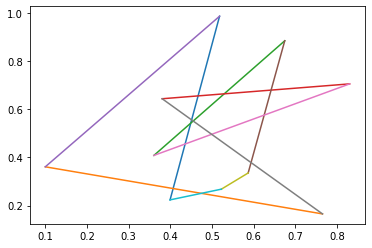

In [ ]:
# indices = get_route_indices(best_path)
for i in indices[1:]:
    plt.plot([city_x[i], city_x[i-1]], [city_y[i], city_y[i-1]], '-')
plt.show()